In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from Bio import SeqIO
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio import Align

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

In [2]:
# Functions to read the tRNA transcript fasta files:
DNAcompRNA = {a: b for a, b in zip('ATGC', 'UACG')}
def anticodon2codon(anticodon):
    codon = ''.join([DNAcompRNA[b] for b in anticodon[::-1]])
    return(codon)

def read_tRNAdb_info(tRNA_database):
    # Read the tRNA database to find the length of each sequence:
    tRNA_data = dict()
    for species in tRNA_database:
        for record in SeqIO.parse(tRNA_database[species], "fasta"):
            tRNA_data[record.id] = dict()
            tRNA_data[record.id]['species'] = species
            if species != 'ecoli' and 'Escherichia_coli' in record.id:
                ecoli_ctr = True
                tRNA_data[record.id]['ecoli_ctr'] = True
            else:
                tRNA_data[record.id]['ecoli_ctr'] = False
            
            if 'mito' in record.id:
                tRNA_data[record.id]['mito'] = True
            else:
                tRNA_data[record.id]['mito'] = False
            
            tRNA_data[record.id]['len'] = len(record.seq)
            tRNA_data[record.id]['codon'] = anticodon2codon(record.id.split('-')[2])
            tRNA_data[record.id]['anticodon'] = record.id.split('-')[2]
            tRNA_data[record.id]['amino_acid'] = record.id.split('-')[1]
            tRNA_data[record.id]['seq'] = str(record.seq)
    return(tRNA_data)

In [3]:
# Read the tRNA transcript into a dataframe:
tRNA_database = dict()
tRNA_database['human'] = 'tRNA_database/human/hg38-tRNAs.fa'
tRNA_database['mouse'] = 'tRNA_database/mouse/mm10-tRNAs.fa'

db_dict = read_tRNAdb_info(tRNA_database)
tRNA_df = pd.DataFrame(db_dict).transpose()
tRNA_df = tRNA_df.reset_index()
tRNA_df = tRNA_df.rename(columns={"index": "seq_id"})

# Get rid of 1/2 in mito Leu amino acid name:
tRNA_df['amino_acid'] = [AA[:-1] if AA[-1]=='1' or AA[-1]=='2' else AA for AA in tRNA_df['amino_acid'].values]

# Add column for mito, amino acid - codon:
mac_list = list()
for m, a, c in zip(tRNA_df['mito'], tRNA_df['amino_acid'], tRNA_df['codon']):
    if m:
        m_pre = 'm'
    else:
        m_pre = 'c'
    
    mac = m_pre + '-' + a + '-' + c
    mac_list.append(mac)
tRNA_df['mac'] = mac_list

# Print a sample of the human tRNA transcripts:
hs_mask = (tRNA_df['species'] == 'human') & (~tRNA_df['ecoli_ctr'])
tRNA_df[hs_mask].head(3)

,seq_id,species,ecoli_ctr,mito,len,codon,anticodon,amino_acid,seq,mac
1,Homo_sapiens_mito_tRNA-Ala-TGC,human,False,True,72,GCA,TGC,Ala,AAGGGCTTAGCTTAATTAAAGTGGCTGATTTGCGTTCAGTTGATGC...,m-Ala-GCA
2,Homo_sapiens_mito_tRNA-Arg-TCG,human,False,True,68,CGA,TCG,Arg,TGGTATATAGTTTAAACAAAACGAATGATTTCGACTCATTAAATTA...,m-Arg-CGA
3,Homo_sapiens_mito_tRNA-Asn-GTT,human,False,True,76,AAC,GTT,Asn,TAGATTGAAGCCAGTTGATTAGGGTGCTTAGCTGTTAACTAAGTGT...,m-Asn-AAC


In [4]:
# Dump a table of the length distribution
# of the transcripts:
with open('tRNA-len_table.tab', 'w') as fh:
    print('{}\t{}'.format('Length', 'tRNAs'), file=fh)
    tRNA_df_gp = tRNA_df[hs_mask].groupby('len').agg({'mac': list}).reset_index()
    for _, row in tRNA_df_gp.iterrows():
        mac = set(row['mac'])
        mac_str = ', '.join(list(mac))
        print('{}\t{}'.format(row['len'], mac_str), file=fh)

In [5]:
def pairwise_dist_mat(tRNA_dict, indicator='codon', N3p_bases=0, \
                      match_score=1, mismatch_score=-1, \
                      open_gap_score=-2, extend_gap_score=-2):
    '''
    Find the pairwise distance between tRNA transcripts.
    Distance is defined as counts of mismatches and gaps
    after global alignment.
    Break down the data by an "indicator" e.g.
    same codon or same amino acid.
    '''
    
    # Extract data required:
    seq_list = [s[-N3p_bases:] for s in tRNA_dict['seq'].values]
    indi_list = tRNA_dict[indicator].values
    id_list = tRNA_dict['seq_id'].values

    # Store distances in matrix:
    dist_mat = np.empty((len(seq_list), len(seq_list)))
    dist_mat[:] = np.nan
    # Indicator matrix, if same indicator (e.g. codon) or not:
    indi_mat = np.full((len(seq_list), len(seq_list)), False)
    # Id matrix to ID the elements:
    id_mat = np.empty((len(seq_list), len(seq_list)), dtype='<U256')
    
    # Initiate the aligner:
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = match_score
    aligner.mismatch_score = mismatch_score
    aligner.open_gap_score = open_gap_score
    aligner.extend_gap_score = extend_gap_score
    # Fill the distance matrix:
    for row_i in range(len(seq_list)):
        for row_j in range(row_i+1, len(seq_list)):
            target = seq_list[row_i]
            query = seq_list[row_j]
            alignments = aligner.align(target, query)
            alignment = alignments[0]
            t_cor, q_cor = alignment.aligned
            q_gaps = sum(t_cor[i][0]-t_cor[i-1][1] for i in range(1, len(t_cor)))
            t_gaps = sum(q_cor[i][0]-q_cor[i-1][1] for i in range(1, len(q_cor)))
            mismatches = alignment.substitutions.sum() - alignment.substitutions.trace()
            dist_mat[row_i, row_j] = q_gaps + t_gaps + mismatches
            indi_mat[row_i, row_j] = indi_list[row_i] == indi_list[row_j]
            id_mat[row_i, row_j] = id_list[row_i] + '@' + id_list[row_j]

    # Make dataframe of distances broken down by the indicator:
    Ndist = int((dist_mat.shape[0]**2 - dist_mat.shape[0])/2)
    df_dist = pd.DataFrame(columns=['Same indicator', 'Distance'], index=range(Ndist))

    upper_mask = np.triu(np.ones_like(dist_mat, dtype=bool), k=1)

    dist_lst = list()
    same_codon = list()
    dist_arr = dist_mat[indi_mat&upper_mask]
    dist_lst.extend(dist_arr)
    same_codon.extend([True]*len(dist_arr))

    dist_arr = dist_mat[~indi_mat&upper_mask]
    dist_lst.extend(dist_arr)
    same_codon.extend([False]*len(dist_arr))

    df_dist['Same indicator'] = same_codon
    df_dist['Distance'] = list(map(int, dist_lst))

    return(df_dist, dist_mat, indi_mat, id_mat)


In [6]:
# Find distances:
hs_mask = (tRNA_df['species'] == 'human') & (~tRNA_df['ecoli_ctr'])

df_dist_full_codon, _, _, _ = pairwise_dist_mat(tRNA_df[hs_mask], indicator='codon', N3p_bases=0)
df_dist_full_aa, _, _, _ = pairwise_dist_mat(tRNA_df[hs_mask], indicator='amino_acid', N3p_bases=0)
df_dist_25_codon, _, _, _ = pairwise_dist_mat(tRNA_df[hs_mask], indicator='codon', N3p_bases=25)
df_dist_25_aa, _, _, _ = pairwise_dist_mat(tRNA_df[hs_mask], indicator='amino_acid', N3p_bases=25)

# Rename indicator:
df_dist_full_codon = df_dist_full_codon.rename(columns={'Same indicator': 'Same codon'})
df_dist_full_aa = df_dist_full_aa.rename(columns={'Same indicator': 'Same amino acid'})
df_dist_25_codon = df_dist_25_codon.rename(columns={'Same indicator': 'Same codon'})
df_dist_25_aa = df_dist_25_aa.rename(columns={'Same indicator': 'Same amino acid'})


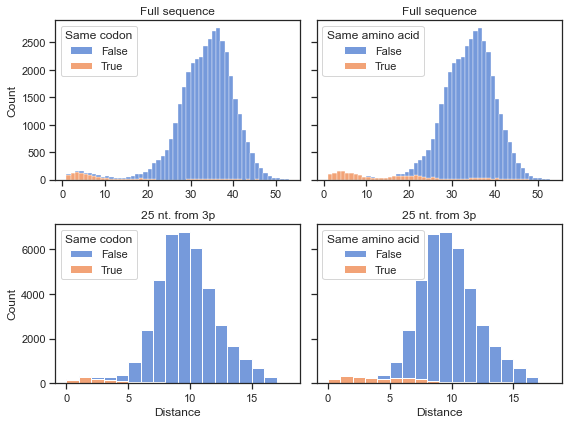

In [7]:
# Do the plotting:
plot_fnam_pdf = 'dist_hist.pdf'
plot_fnam_png = 'dist_hist.png'

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)


# First row is the full sequence comparison:
Nbins = df_dist_full_codon['Distance'].max() - df_dist_full_codon['Distance'].min()
g1 = sns.histplot(ax=ax1, data=df_dist_full_codon, x='Distance', hue='Same codon', multiple="stack", bins=Nbins)
g1.set_title('Full sequence')
g1.set_xlabel('')
sns.move_legend(g1, "upper left")

Nbins = df_dist_full_aa['Distance'].max() - df_dist_full_aa['Distance'].min()
g2 = sns.histplot(ax=ax2, data=df_dist_full_aa, x='Distance', hue='Same amino acid', multiple="stack", bins=Nbins)
g2.set_title('Full sequence')
g2.set_ylabel('')
g2.set_xlabel('')
sns.move_legend(g2, "upper left")


# Second row is the comparison between 25 nt. from 3p:
Nbins = df_dist_25_codon['Distance'].max() - df_dist_25_codon['Distance'].min()
g3 = sns.histplot(ax=ax3, data=df_dist_25_codon, x='Distance', hue='Same codon', multiple="stack", bins=Nbins)
g3.set_title('25 nt. from 3p')
sns.move_legend(g3, "upper left")

Nbins = df_dist_25_aa['Distance'].max() - df_dist_25_aa['Distance'].min()
g4 = sns.histplot(ax=ax4, data=df_dist_25_aa, x='Distance', hue='Same amino acid', multiple="stack", bins=Nbins)
g4.set_title('25 nt. from 3p')
g4.set_ylabel('')
sns.move_legend(g4, "upper left")

# Remove ticks from shared axis:
ax2.tick_params(labelleft=False)
ax4.tick_params(labelleft=False)


fig.tight_layout()

fig.savefig(plot_fnam_pdf, bbox_inches='tight')
fig.savefig(plot_fnam_png, bbox_inches='tight', dpi=300)